### Bike Sharing Demand - Linear Regression

In [1]:
# supress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing required libraries
import numpy as np  
import pandas as pd 

# for Visualization 
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# for the model preparation and testing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm

#### 1. Reading Understanding and Visualizing the data

In [4]:
# reading the dataset
df = pd.read_csv('day.csv')
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,1,1,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,2,1,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,3,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,4,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,5,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [5]:
# shape of the data 
df.shape

(730, 16)

In [6]:
# Columns that we can remove

# instant is nothing but index variable
# dteday: we already have month and year, 
# temp & atemp, this is temp in celcius and actual temp felt by the person. so we can remove the atemp as a column from the dataset.
# casual and registered because we are going to work on the total cnt

# we'll save this updated dataframe to bike data set

In [7]:
df.columns

Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')

In [8]:
bike = df[['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'hum', 'windspeed', 'cnt']]
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,1,0,1,0,1,1,2,14.110847,80.5833,10.749882,985
1,1,0,1,0,2,1,2,14.902598,69.6087,16.652113,801
2,1,0,1,0,3,1,1,8.050924,43.7273,16.636703,1349
3,1,0,1,0,4,1,1,8.200000,59.0435,10.739832,1562
4,1,0,1,0,5,1,1,9.305237,43.6957,12.522300,1600


In [9]:
# information about the data
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   hum         730 non-null    float64
 9   windspeed   730 non-null    float64
 10  cnt         730 non-null    int64  
dtypes: float64(3), int64(8)
memory usage: 62.9 KB


In [10]:
# checking for null values
round(bike.isnull().sum()/len(bike),2).sort_values(ascending = False)

season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
hum           0.0
windspeed     0.0
cnt           0.0
dtype: float64

In [11]:
bike.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.995890,0.690411,1.394521,20.319259,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.000339,0.462641,0.544807,7.506729,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,97.250000,34.000021,8714.000000


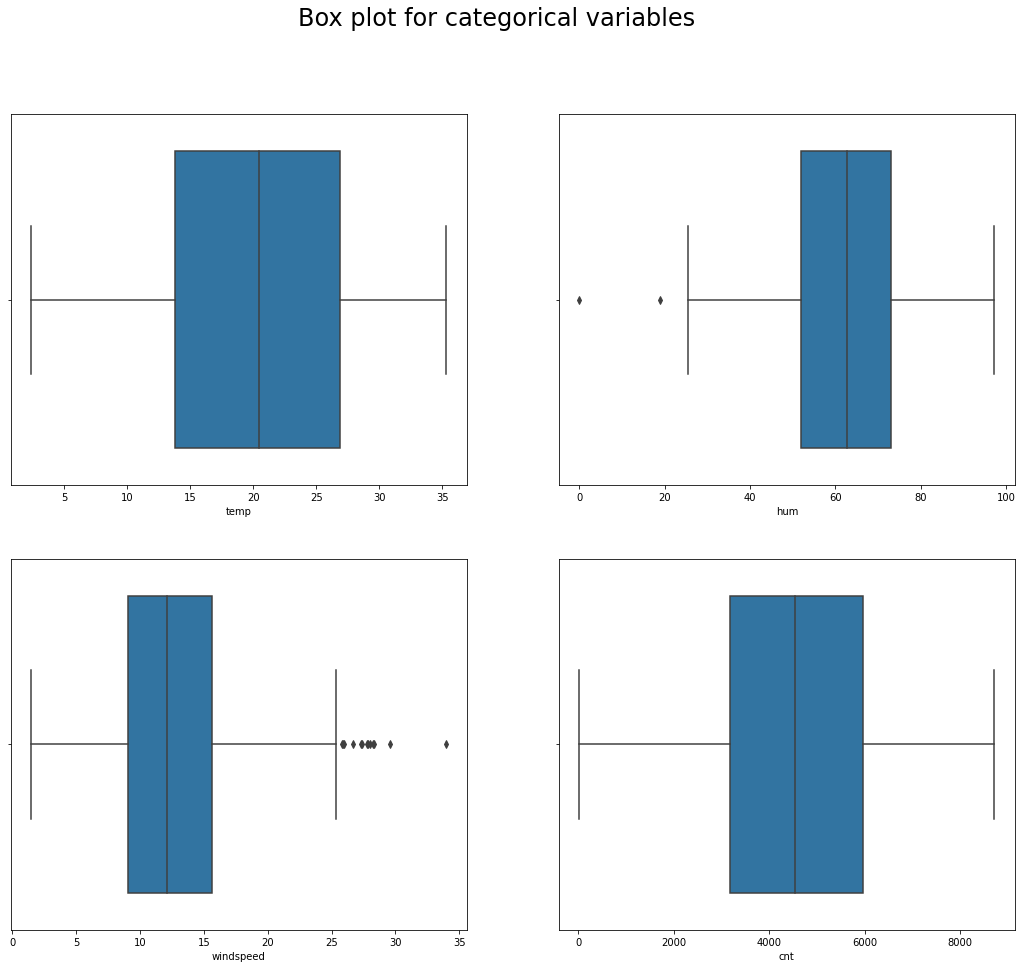

In [23]:
# plotting box plot for the continous variable to find outliers for subplots

cont_variable =  bike[['temp','hum', 'windspeed', 'cnt']]

plt.figure(figsize = [18,15])
plt.suptitle('Box plot for categorical variables',fontsize =  24)
for i in range(len(cont_variable.columns)):    
    plt.subplot(2,2,i+1)
    sns.boxplot(x = list(cont_variable.columns)[i], 
                data = bike)
plt.show()


In [13]:
# insights show here that:
# 1. windspped and hum both the columns have some outlier values


In [14]:
# finding the percentage of outlier values in both the columns

# get percentage outlier for hum and windspeed

# function to get outlier percentage
def percentage_outlier(x):
    iqr = df[x].quantile(0.75)-df[x].quantile(0.25)
    HL = df[x].quantile(0.75)+iqr*1.5
    LL = df[x].quantile(0.25)-iqr*1.5
    per_outlier = ((df[x]<LL).sum()+(df[x]>HL).sum())/len(df[x])*100
    per_outlier = round(per_outlier,2)
    return(per_outlier)

print('Percentage of outlier (hum): ', percentage_outlier('hum'))
print('Percentage of outlier (windspeed): ', percentage_outlier('windspeed'))

Percentage of outlier (hum):  0.27
Percentage of outlier (windspeed):  1.78


In [15]:
# insights, there is no significnt abnormalities so we can ignore it.

In [16]:
# convertng to the category variable
bike['season'] = bike['season'].astype('category')
bike['yr'] = bike['yr'].astype('category')
bike['mnth'] = bike['mnth'].astype('category')
bike['holiday'] = bike['holiday'].astype('category')
bike['weekday'] = bike['weekday'].astype('category')
bike['workingday'] = bike['workingday'].astype('category')
bike['weathersit'] = bike['weathersit'].astype('category')

In [17]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      730 non-null    category
 1   yr          730 non-null    category
 2   mnth        730 non-null    category
 3   holiday     730 non-null    category
 4   weekday     730 non-null    category
 5   workingday  730 non-null    category
 6   weathersit  730 non-null    category
 7   temp        730 non-null    float64 
 8   hum         730 non-null    float64 
 9   windspeed   730 non-null    float64 
 10  cnt         730 non-null    int64   
dtypes: category(7), float64(3), int64(1)
memory usage: 29.4 KB


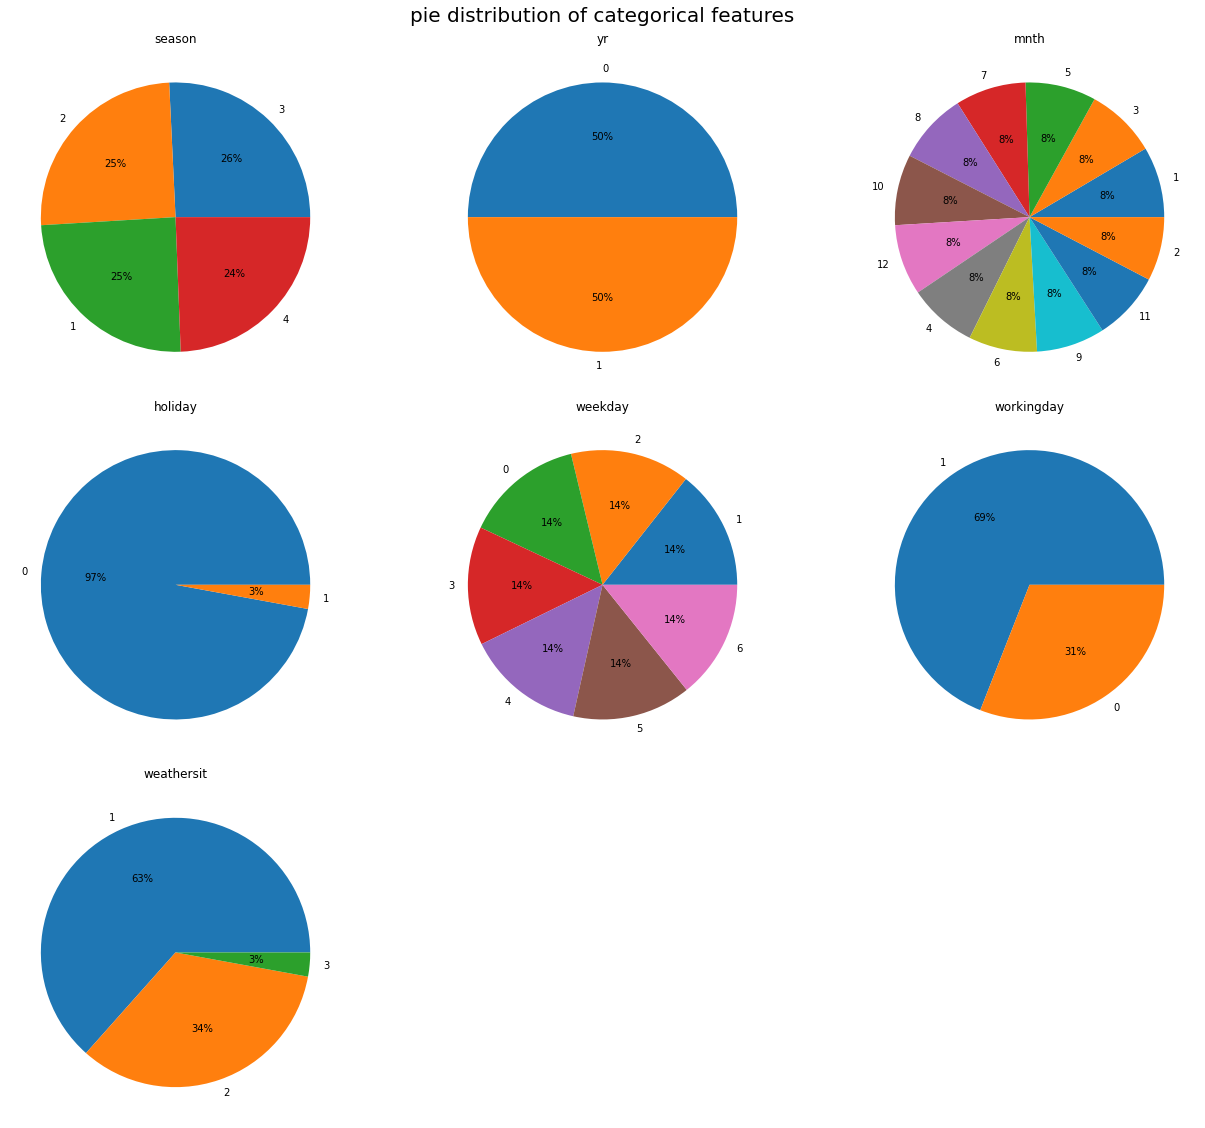

In [36]:
# visualising the category variables using pie chart
category_var = bike[['season', 'yr', 'mnth', 'holiday', 'weekday',
       'workingday', 'weathersit']]

plt.figure(figsize=(18,16))
plt.suptitle('pie distribution of categorical features', fontsize=20)
for i in range(len(category_var.columns)):
    plt.subplot(3,3,i+1)
    f=plt.gca()
    f.set_title(category_var.columns.values[i])
    values=category_var.iloc[:,i].value_counts(normalize=True).values
    index=n=category_var.iloc[:,i].value_counts(normalize=True).index
    plt.pie(values,labels=index,autopct='%1.0f%%')
plt.tight_layout(pad = 1.5)
plt.show()

In [ ]:
# **Insights:**
# - Seasons:   We could see business was operating similar days in all four seasons.
# - Yr:   Number of days operation in both the year are almost same.
# - Month: We could see business was operating similar days in all 12 months.
# - Holiday: Business was operating in 3% days of holiday
# - weekdays: We could see business was operating similar percentage in all weekdays.
# - Workingday: Bisuness was operating in 68% in workign days and 32% in nonworking days.
# - Weathersit: From the above analaysis it is being observed that there is no data for 4th category of `weathersit 
#   i.e Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog`.May be the company is not operating on those days or there was no demand of bike.

In [37]:
type(cont_variable)
type(category_var)

pandas.core.frame.DataFrame

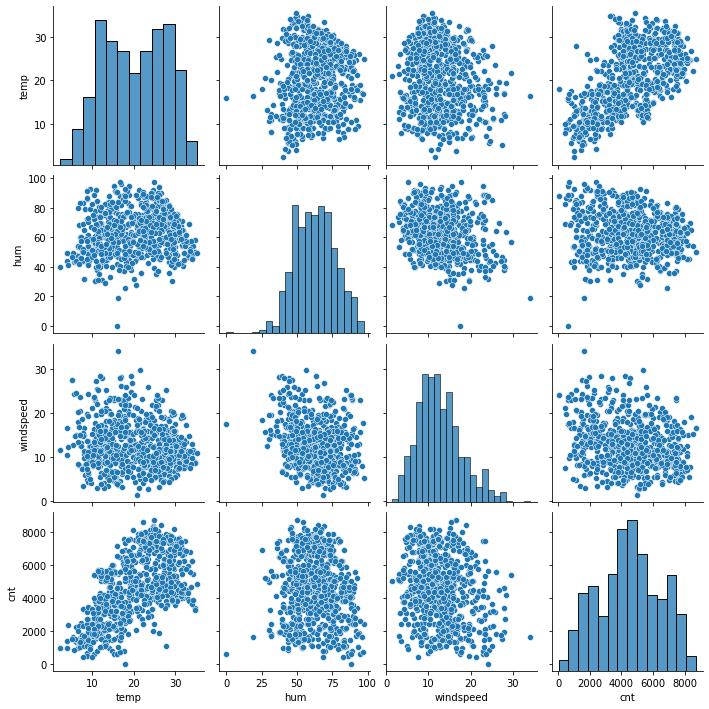

In [ ]:
#pair plots for continuous datatypes
sns.pairplot(cont_variable)
plt.show()

 `temp` has highest positive correlation with target variable `cnt`.

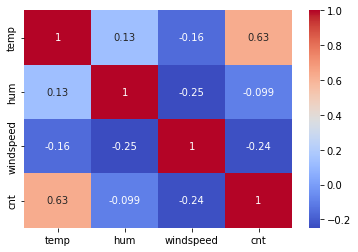

In [ ]:
# look at the correaltion between continous varibales using heat map
sns.heatmap(bike.corr(), annot=True, cmap='coolwarm')
plt.show()

 - A positive correalation observed between `cnt` and `temp` (0.63)
 - A Negative correlation observed for `cnt` with `hum` and `windspeed` (-0.099 and -0.24)

In [ ]:
columns = len(category_var.columns)
type(columns)

int

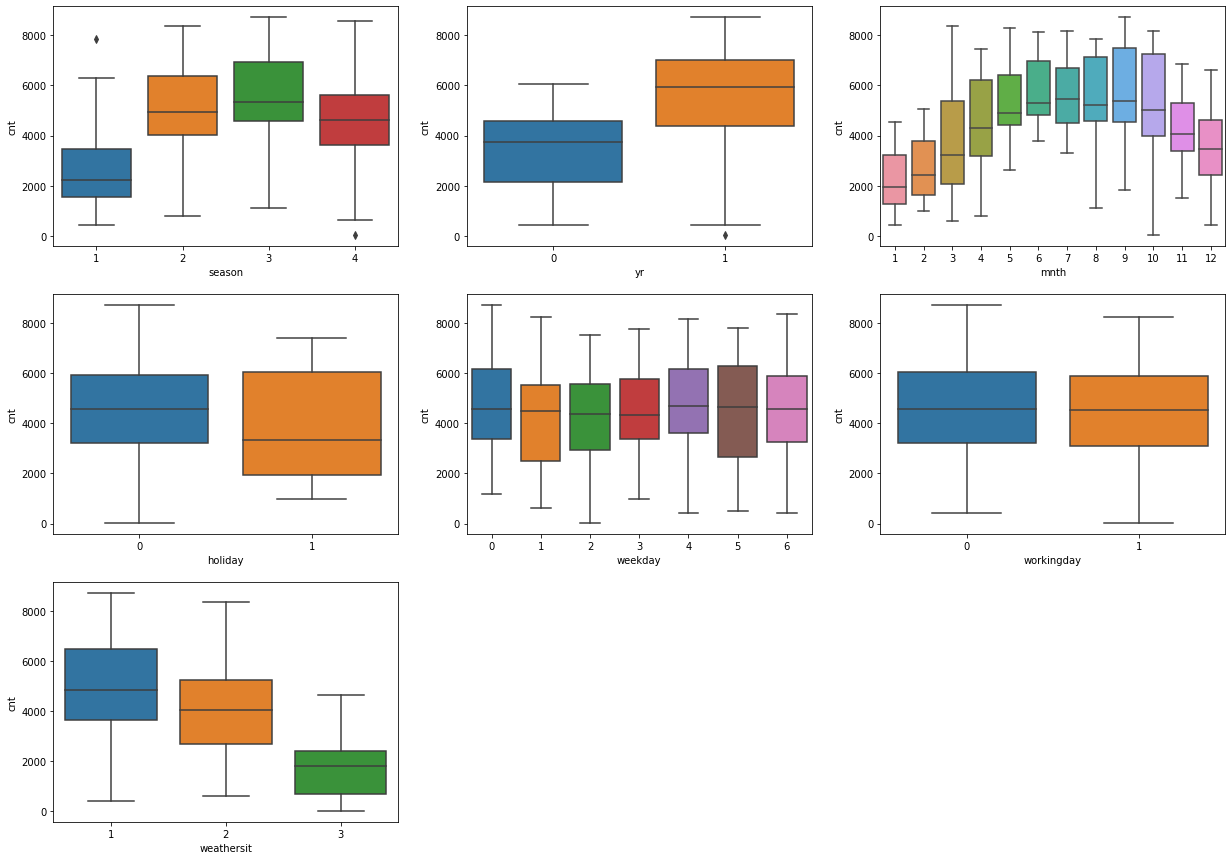

In [ ]:
plt.figure(figsize = [21,15])
plt.title('Box plot for categorical variables')
for i in range(len(category_var.columns)):    
    plt.subplot(3,3,i+1)
    
    red_diamond = dict(markerfacecolor='r', marker='D')
    sns.boxplot(x = list(category_var.columns)[i], 
                y = bike.cnt, 
                data = bike)
# plt.ticklabel_format(style='plain', axis='y')
# plt.xticks(rotation=90)

In [ ]:
# # INSIGHTS
# The demad of bike is less in the month of `spring` when compared with other seasons
# - The demand bike increased in the year 2019 when compared with year 2018.
# - Month Jun to Sep is the period when bike demand is high. The Month Jan is the lowest demand month.
# - Bike demand is less in holidays in comparison to not being holiday.
# - The demand of bike is almost similar throughout the weekdays.
# - There is no significant change in bike demand with workign day and non working day.
# - The bike demand is high when weather is `clear and Few clouds` however demand is less in case of `Lightsnow and light rainfall`. 
# We do not have any dat for `Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog` , 
# so we can not derive any conclusion. May be the company is not operating on those days or there is no demand of bike.

#### Preparing the data
##### Creating Dummy variables

In [ ]:
# Creating the dummy variables for the variables, season, mnth, weekday and weathersit
dummy_var = pd.get_dummies(bike[['season', 'mnth', 'weekday', 'weathersit']], drop_first=True)

# Concating the Dummy variables with the working dataset
bike = pd.concat([bike, dummy_var], axis=1)

# Dropping the columns: season, mnth, weekday, weathersit as we have created the dummy variables
bike.drop(['season', 'mnth', 'weekday', 'weathersit'], axis=1, inplace=True)

bike.head()


,yr,holiday,workingday,temp,hum,windspeed,cnt,season_2,season_3,season_4,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,0,0,1,14.110847,80.5833,10.749882,985,0,0,0,...,0,0,1,0,0,0,0,0,1,0
1,0,0,1,14.902598,69.6087,16.652113,801,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,1,8.050924,43.7273,16.636703,1349,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,59.0435,10.739832,1562,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,1,9.305237,43.6957,12.522300,1600,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
bike.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'season_2', 'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4',
       'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11',
       'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [ ]:
# Drop_first: the reason we usee this is so that that the categoryvariables tha we have are 12 and we require only 11 dummies to view the dta

In [ ]:
bike.shape

(730, 29)

In [ ]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   yr            730 non-null    category
 1   holiday       730 non-null    category
 2   workingday    730 non-null    category
 3   temp          730 non-null    float64 
 4   hum           730 non-null    float64 
 5   windspeed     730 non-null    float64 
 6   cnt           730 non-null    int64   
 7   season_2      730 non-null    uint8   
 8   season_3      730 non-null    uint8   
 9   season_4      730 non-null    uint8   
 10  mnth_2        730 non-null    uint8   
 11  mnth_3        730 non-null    uint8   
 12  mnth_4        730 non-null    uint8   
 13  mnth_5        730 non-null    uint8   
 14  mnth_6        730 non-null    uint8   
 15  mnth_7        730 non-null    uint8   
 16  mnth_8        730 non-null    uint8   
 17  mnth_9        730 non-null    uint8   
 18  mnth_10   

In [ ]:
# Convert categorical columns to numeric 
bike[['yr','holiday','workingday']]= df[['yr','holiday','workingday']].astype('uint8')
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            730 non-null    uint8  
 1   holiday       730 non-null    uint8  
 2   workingday    730 non-null    uint8  
 3   temp          730 non-null    float64
 4   hum           730 non-null    float64
 5   windspeed     730 non-null    float64
 6   cnt           730 non-null    int64  
 7   season_2      730 non-null    uint8  
 8   season_3      730 non-null    uint8  
 9   season_4      730 non-null    uint8  
 10  mnth_2        730 non-null    uint8  
 11  mnth_3        730 non-null    uint8  
 12  mnth_4        730 non-null    uint8  
 13  mnth_5        730 non-null    uint8  
 14  mnth_6        730 non-null    uint8  
 15  mnth_7        730 non-null    uint8  
 16  mnth_8        730 non-null    uint8  
 17  mnth_9        730 non-null    uint8  
 18  mnth_10       730 non-null    

#### Splitting the data into TEST-TRAIN Dataset

In [ ]:
# Split train test dataset
# Making a 70 30 split for the dataset

bike_train, bike_test = train_test_split(bike, train_size=0.7, random_state=10)

In [ ]:
print(bike_train.shape)
print(bike_test.shape)

(510, 29)
(220, 29)


##### Scaling the dataset

We can see that the numeric data has wide range of values, 
we can normalise the values to sccale them down 

In [ ]:
num_var = ['temp', 'hum', 'windspeed','cnt']

In [ ]:
# scale the train dataset

scaler = MinMaxScaler()

# fit and tranform on the training dataset
bike_train[num_var] = scaler.fit_transform(bike_train[num_var])
bike_train.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_2,season_3,season_4,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
72,0,0,1,0.298094,0.393891,0.236118,0.194978,0,0,0,...,0,0,0,0,1,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,0.737052,1,0,0,...,0,0,0,0,0,0,0,0,0,0
700,1,0,1,0.327249,0.809877,0.210252,0.509236,0,0,1,...,0,1,1,0,0,0,0,0,1,0
264,0,0,0,0.694699,0.910249,0.217975,0.526862,0,1,0,...,0,0,0,0,0,0,0,1,1,0
577,1,0,1,0.811368,0.624004,0.244886,0.863093,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
bike_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_2,season_3,season_4,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
566,1,0,0,24.429153,86.5417,14.291100,4459,0,1,0,...,0,0,0,0,0,0,0,0,0,1
374,1,0,1,12.656536,64.6522,12.565984,3598,0,0,0,...,0,0,0,0,0,1,0,0,0,0
181,0,0,0,29.622500,39.6250,6.874736,5362,0,1,0,...,0,0,0,0,0,0,0,0,0,0
529,1,0,1,26.581653,56.9583,17.000111,7363,1,0,0,...,0,0,0,0,0,0,1,0,0,0
233,0,0,1,28.358347,47.0000,18.542250,4758,0,1,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# transform thr test dataset
bike_test[num_var] = scaler.transform(bike_test[num_var])
bike_test.head()

,yr,holiday,workingday,temp,hum,windspeed,cnt,season_2,season_3,season_4,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
566,1,0,0,0.652175,0.863516,0.393568,0.486297,0,1,0,...,0,0,0,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0.382349,0,0,0,...,0,0,0,0,0,1,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0.595316,0,1,0,...,0,0,0,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,0.836895,1,0,0,...,0,0,0,0,0,0,1,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0.522395,0,1,0,...,0,0,0,0,1,0,0,0,0,0


Split data set into X and y sets (for both train and test set)

In [ ]:
y_train = bike_train.pop('cnt')
X_train = bike_train
X_train.head()

,yr,holiday,workingday,temp,hum,windspeed,season_2,season_3,season_4,mnth_2,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
72,0,0,1,0.298094,0.393891,0.236118,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
510,1,0,0,0.778657,0.694105,0.364071,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
700,1,0,1,0.327249,0.809877,0.210252,0,0,1,0,...,0,1,1,0,0,0,0,0,1,0
264,0,0,0,0.694699,0.910249,0.217975,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
577,1,0,1,0.811368,0.624004,0.244886,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
# creating the X and y data dataframe for the test set
y_test = bike_test.pop('cnt')
X_test = bike_test

X_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_2,season_3,season_4,mnth_2,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


#### RFE - Recursive Feature Elemination

In [ ]:
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'season_2',
       'season_3', 'season_4', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5',
       'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [ ]:
# Running RFE to select the varibles

# Create object
lm = LinearRegression()

# fit model
lm.fit(X_train, y_train)

# run RFE
rfe = RFE(estimator=lm,n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

# Select columns
col = X_train.columns[rfe.support_]
len(col)

15

##### Building the model with statmodels

In [ ]:
# Creating X_train_rfe with the rfe selected columns
X_train_rfe = X_train[col]

In [ ]:
# creating a function for statistical linear model

def sm_linearmodel(X_train_sm):
    # adding constant
    X_train_sm = sm.add_constant(X_train_sm)

    # Creating a fitted model
    lm = sm.OLS(y_train, X_train_sm).fit()
    return lm

In [ ]:
# function to calculate the VIF
# calculate VIF

def vif_calc(X):
    vif = pd.DataFrame()
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'],2)
    vif = vif.sort_values(by='VIF', ascending = False)
    return vif

In [ ]:
# Create 1st stats model and look for summary and VIF
lm_1 = sm_linearmodel(X_train_rfe)
print(lm_1.summary())

# Calculate VIF
print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     180.5
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          2.39e-189
Time:                        18:04:32   Log-Likelihood:                 489.38
No. Observations:                 510   AIC:                            -946.8
Df Residuals:                     494   BIC:                            -879.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1956      0.025      7.982   

In [ ]:
# Loop to remove P value variables >0.05 in bstep mannen and update model

pvalue = lm_1.pvalues
while(max(pvalue)>0.05):
    maxp_var = pvalue[pvalue == pvalue.max()].index
    print('Removed variable:' , maxp_var[0], '    P value: ', round(max(pvalue),3))
    
    # drop variable with high p value
    X_train_rfe = X_train_rfe.drop(maxp_var, axis = 1)
    lm_1 = sm_linearmodel(X_train_rfe)
    pvalue = lm_1.pvalues
    
    

Removed variable: mnth_5     P value:  0.054
Removed variable: mnth_8     P value:  0.056


**Insights:**
- One step model upadation hapenned in the above step.
- Highest pvalue in the mdoel; `mnth_5 : 0.054` and `mnth_8 : 0.056`. As the pvalue is >0.05 it is insignificant for the model, so `mnth_5` and `mnth_8` are dropped and model updated.
- pvalues for all the varibles are < 0.05 so we will look for summary and VIF of model `lm_1`.

In [ ]:
# Look for sumamry of model
print(lm_1.summary())

# Calculate VIF
print(vif_calc(X_train_rfe))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     205.5
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          4.51e-190
Time:                        18:04:32   Log-Likelihood:                 485.58
No. Observations:                 510   AIC:                            -943.2
Df Residuals:                     496   BIC:                            -883.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1870      0.024      7.656   

**Insight**
- R2: 0.843 and adj R2: 0.839, all the varibales have the pvalue < 0.05.
- VIF: temp variable has a very high VIF value of `19.22`. But during EDA we found out that the `temp` value has a high correlation factor with the `cnt`. PLus this is an important variable based on business understanding of the model.
- the next variable with the high VIF value comes out to be `hum`(12.09). So, we will drop the variable and update the model again for the result.


In [ ]:
# drop varible having high VIF
X_train_new = X_train_rfe.drop(['hum'],axis = 1)

# Create stats model and look for summary
lm_2 = sm_linearmodel(X_train_new)
print(lm_2.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     211.3
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          2.17e-186
Time:                        18:04:32   Log-Likelihood:                 474.04
No. Observations:                 510   AIC:                            -922.1
Df Residuals:                     497   BIC:                            -867.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1065      0.018      5.878   

**Insight**
- No significant change noticed after droping the `hum` variable since the the R2: `0.836` value and Adj R2: `0.832` value havent changed much.
- The next Highest VIF value comes out to be season_3 of `6.08`. thus drroping and updating the model

In [ ]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['season_3'],axis = 1)

# Create stats model and look for summary
lm_3 = sm_linearmodel(X_train_new)
print(lm_3.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.824
Method:                 Least Squares   F-statistic:                     217.0
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          5.89e-182
Time:                        18:04:32   Log-Likelihood:                 460.73
No. Observations:                 510   AIC:                            -897.5
Df Residuals:                     498   BIC:                            -846.6
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0943      0.018      5.122   

**Insiight**
- The R2 and Adj R2 didnt change much and reduced to 0.827 and 0.824 respectively.
- so we have removed the values with high pvalue and high VIF value.
- Next we'll remove the highest pvalue variable, updating the model and training it again.

In [ ]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['mnth_3'],axis = 1)

# Create stats model and look for summary
lm_4 = sm_linearmodel(X_train_new)
print(lm_4.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.822
Method:                 Least Squares   F-statistic:                     235.9
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          5.83e-182
Time:                        18:04:32   Log-Likelihood:                 457.90
No. Observations:                 510   AIC:                            -893.8
Df Residuals:                     499   BIC:                            -847.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1029      0.018      5.677   

**Insight**
- R2: 0.825 and Adj R2 0.822 are the respective values which havent changed from the last model training. thus our option of droping the mnth_3 model is good.
- All the VIF values remain under 5 which is perfect.
- Now removing the next pvalue of mnth_10 with a value of `0.002`.
- Removing and updating the model.

In [ ]:
# drop varible having high VIF
X_train_new = X_train_new.drop(['mnth_10'],axis = 1)

# Create stats model and look for summary
lm_5 = sm_linearmodel(X_train_new)
print(lm_5.summary())

# Calculate VIF
print(vif_calc(X_train_new))

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     256.8
Date:                Tue, 27 Jun 2023   Prob (F-statistic):          3.57e-181
Time:                        18:04:32   Log-Likelihood:                 453.17
No. Observations:                 510   AIC:                            -886.3
Df Residuals:                     500   BIC:                            -844.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0969      0.018      5.330   

**Insight**
- Dropping the mnth_10 and updating the model changed the R2: `0.822` and Adj R2: `0.819`. So, not much the value has changed. 
- Final conclusion that we have here is the all the pvalues almost 0 and VIF <5
- No signifcant change in the Adj R2 value of the `lm_4` and `lm_5` model. thus we will be chosing `lm_5` as our final model.

In [ ]:
# List down final model varibales and its coefficients

# assign final model to lm_final
lm_final = lm_5

# list down and check variables of final model
var_final = list(lm_final.params.index)
var_final.remove('const')
print('Final Selected Variables:', var_final)

# Print the coefficents of final varible
print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

Final Selected Variables: ['yr', 'holiday', 'temp', 'windspeed', 'season_2', 'season_4', 'mnth_9', 'weathersit_2', 'weathersit_3']

Coefficent for the variables are:
const           0.097
yr              0.256
holiday        -0.097
temp            0.552
windspeed      -0.135
season_2        0.092
season_4        0.143
mnth_9          0.093
weathersit_2   -0.085
weathersit_3   -0.264
dtype: float64


#### Residual Analysis

##### model Evaluation on the Training Set

In [ ]:
# Selecting the final varibales for the test dataset
X_train_res = X_train[var_final]

In [ ]:
# Adding a constant
X_train_res = sm.add_constant(X_train_res)

# predict train set
y_train_pred = lm_final.predict(X_train_res)

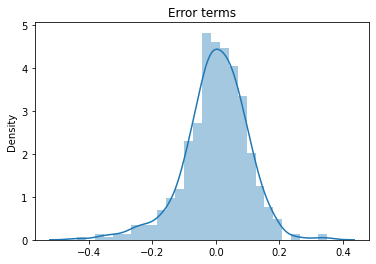

In [ ]:
# distrubition plot for residue
res = y_train - y_train_pred
sns.distplot(res)
plt.title('Error terms')
plt.show()

Text(0, 0.5, 'Residual')

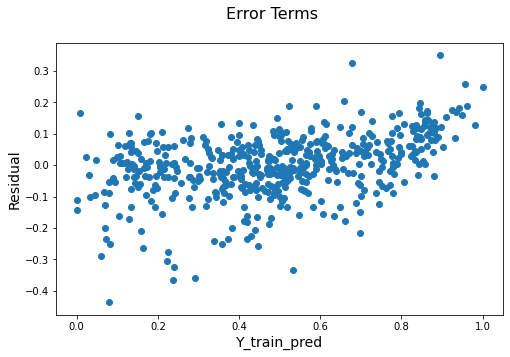

In [ ]:
# The distribution plot of error term show the normal distribution with the mean at ZERO

# Error terms train set
c = [i for i in range(1,len(y_train)+1,1)]
fig = plt.figure(figsize=(8,5))
plt.scatter(y_train,res)
fig.suptitle('Error Terms', fontsize=16)          # Plot heading 
plt.xlabel('Y_train_pred', fontsize=14)           # X-label
plt.ylabel('Residual', fontsize=14)               # Y-label

**Insight**
- The residual plot seems to be random
- Also the error terms have the constant variance

#### Prediction on the Test Set

In [ ]:
# check dataframe for the test set
bike_test.head()

,yr,holiday,workingday,temp,hum,windspeed,season_2,season_3,season_4,mnth_2,...,mnth_11,mnth_12,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
566,1,0,0,0.652175,0.863516,0.393568,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
374,1,0,1,0.276477,0.584521,0.340487,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
181,0,0,0,0.817910,0.265533,0.165370,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
529,1,0,1,0.720868,0.486457,0.476922,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
233,0,0,1,0.777567,0.359532,0.524373,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# select final variables from X_test
X_test_sm = X_test[var_final]
X_test_sm.head()

,yr,holiday,temp,windspeed,season_2,season_4,mnth_9,weathersit_2,weathersit_3
566,1,0,0.652175,0.393568,0,0,0,0,1
374,1,0,0.276477,0.340487,0,0,0,0,0
181,0,0,0.817910,0.165370,0,0,0,0,0
529,1,0,0.720868,0.476922,1,0,0,0,0
233,0,0,0.777567,0.524373,0,0,0,0,0


In [ ]:
# add constant
X_test_sm = sm.add_constant(X_test_sm)
X_test_sm.head()

,const,yr,holiday,temp,windspeed,season_2,season_4,mnth_9,weathersit_2,weathersit_3
566,1.0,1,0,0.652175,0.393568,0,0,0,0,1
374,1.0,1,0,0.276477,0.340487,0,0,0,0,0
181,1.0,0,0,0.817910,0.165370,0,0,0,0,0
529,1.0,1,0,0.720868,0.476922,1,0,0,0,0
233,1.0,0,0,0.777567,0.524373,0,0,0,0,0


In [ ]:
# predict test dataset
y_test_pred = lm_final.predict(X_test_sm)

#### Evaluating the Model

In [ ]:
# Get R-Squared fro test dataset
r2_test = r2_score(y_true = y_test, y_pred = y_test_pred)
print('R-Squared for Test dataset: ', round(r2_test,3))

R-Squared for Test dataset:  0.815


In [ ]:
# Adj. R-Squared for test dataset
N= len(X_test)          # sample size
p =len(var_final)     # Number of independent variable
r2_test_adj = round((1-((1-r2_test)*(N-1)/(N-p-1))),3)
print('Adj. R-Squared for Test dataset: ', round(r2_test_adj,3))

Adj. R-Squared for Test dataset:  0.807


In [ ]:
# Mean Sqare Error
mse = mean_squared_error(y_test, y_test_pred)
print('Mean_Squared_Error :' ,round(mse,4))

Mean_Squared_Error : 0.0096


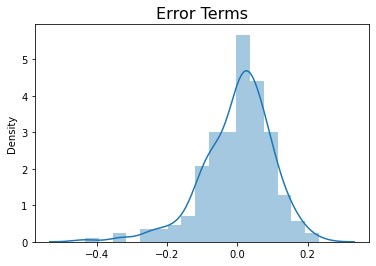

In [ ]:
res_test = y_test - y_test_pred
plt.title('Error Terms', fontsize=16) 
sns.distplot(res_test)
plt.show()

- The distribution plot of error term shows the normal distribution with mean at Zero.

Text(0, 0.5, 'Residual')

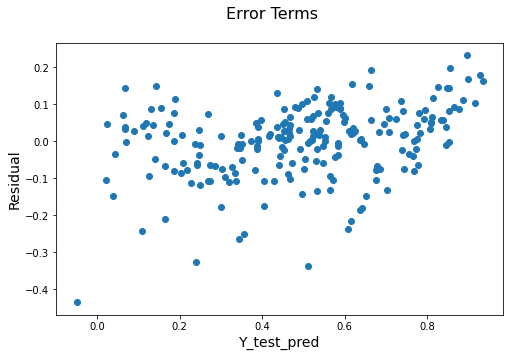

In [ ]:
# Error terms
c = [i for i in range(1,len(y_test)+1,1)]
fig = plt.figure(figsize=(8,5))
plt.scatter(y_test,res_test)
fig.suptitle('Error Terms', fontsize=16)              # Plot heading 
plt.xlabel('Y_test_pred', fontsize=14)                      # X-label
plt.ylabel('Residual', fontsize=14)   

- It seems like the corresponding residual plot is reasonably random.

Text(0, 0.5, 'y_test_pred')

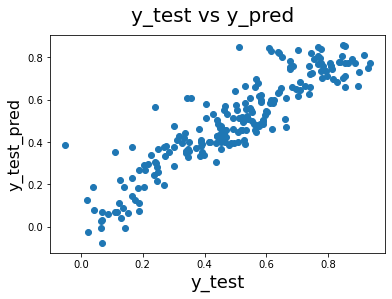

In [ ]:
# Plotting y_test and y_pred to understand the spread

fig = plt.figure()
plt.scatter(y_test, y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize = 20)              # Plot heading 
plt.xlabel('y_test', fontsize = 18)                          # X-label
plt.ylabel('y_test_pred', fontsize = 16)      

**Insights:**
- We can colude that the model `lm_5` fit isn't by chance, and has descent predictive power.

### Step-5: Conclusions

In [ ]:
# Print R Squared and adj. R Squared
print('R- Sqaured train: ', round(lm_final.rsquared,2), '  Adj. R-Squared train:', round(lm_final.rsquared_adj,3) )
print('R- Sqaured test : ', round(r2_test,2), '  Adj. R-Squared test :', round(r2_test_adj,3))

# Print the coefficents of final varible
print('\033[1m{:10s}\033[0m'.format('\nCoefficent for the variables are:'))
print(round(lm_final.params,3))

R- Sqaured train:  0.82   Adj. R-Squared train: 0.819
R- Sqaured test :  0.81   Adj. R-Squared test : 0.807

Coefficent for the variables are:
const           0.097
yr              0.256
holiday        -0.097
temp            0.552
windspeed      -0.135
season_2        0.092
season_4        0.143
mnth_9          0.093
weathersit_2   -0.085
weathersit_3   -0.264
dtype: float64


The equation of our best fitted line is:

$ cnt = 0.097 + (0.256  \times  yr) + (0.097  \times  holiday) + (0.552 \times temp) - (0.135 \times windspeed) + (0.092 \times SeasonSummer) + (0.143 \times SeasonWinter) + (0.093 \times MonthSep) - (0.085 \times WeathersitMistCloudy) - (0.264 \times weathersitLightSnowLightRain) $

- From R-Sqaured and adj R-Sqaured value of both train and test dataset we could conclude that the above variables can well explain more than 80% of bike demand.
- Coeffiencients of the variables explains the factors effecting the bike demand

- Based on final model top three features contributing significantly towards explaining the demand are:
    1. Temperature (0.552)
    2. weathersit : Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds (-0.264)
    3. year (0.256)


- **So it recomended to give these variables utmost importance while planning to achieve maximum demand.**